# 1. 필요한 라이브러리 불러오기
<br><br>
- basemap(세계지도) 설치 -> conda install -c conda-forge basemap
- h5py 설치 -> conda install h5py
- pyhdf 설치 -> conda install -c conda-forge pyhdf
- 나머지 라이브러리는 대부분 'pip install 해당라이브러리 이름' 이런식으로 설치가 가능

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from dplython import *
from scipy.stats import linregress
from IPython.display import Image
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import rcParams
from netCDF4 import Dataset
import struct
import binascii
from mpl_toolkits.basemap import addcyclic
from netCDF4 import num2date, date2num, date2index
import datetime
from pyhdf.SD import SD, SDC
import h5py
import glob
import math

C:\Users\hahw9\Anaconda3\envs\cuda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\hahw9\Anaconda3\envs\cuda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\hahw9\Anaconda3\envs\cuda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\hahw9\Anaconda3\envs\cuda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# 2. 파일 저장 및 불러올 경로 지정하기

In [2]:
data_path = '/home/data4/temporary/Fire_emission_GFED4/'  # -> 현재 저희 서버상 GFED파일이 저장된 경로입니다.
# GFED자료(사용할 데이터들이 담겨있는 폴더)가 저장되어 있는 경로를 입력

save_file_path = '/home/seohyunwoo/wild_code/wildfire'
# 결과로 나오는 그래프를 사진(png)으로 저장할 폴더 입력

In [3]:
# 잠깐 제 환경에 맞게 경로를 바꿔보았습니다.
data_path = 'C:/Users/hahw9/For Coding/Model/hdf5/Data'
save_file_path = 'C:/Users/hahw9/For Coding/Model/hdf5/result'

# 3. 사용할 데이터들에 대해 리스트 인덱싱하기

In [4]:
os.chdir(data_path)
# os.chdir(path) -> 'path' 경로로 작업 디렉토리를 변경

data_list = glob.glob("GFED4.0_MQ*.hdf")
# glob.glob("GFED4.0_MQ*.hdf") -> 현재 디렉토리에서 'GFED4.0_MQ + "아무 문자" + hdf' 로 되어있는 형식의 파일들의 이름을 리스트로 저장

print(data_list[0], " / ", data_list[-1])
# 제가 불러올 데이터의 기간이 2001~2016년이었고 다음과 같이 시작과 끝의 파일 목록을 확인할 수 있었습니다.

cut_data_list = data_list[0:]
# 리스트 인덱싱을 통해 필요한 파일의 이름만 따로 잘라서 cud_data_list에 저장

h5py_data_list = glob.glob("*.hdf5")
# hdf파일(GFED4.0)에는 위도 경도 데이터가 존재하지 않아서 hdf5파일(GFED4.1)에서 위도 경도를 뽑아오기 위해 다음과 같이 hdf5의 리스트도 따로 저장을 했습니다.

GFED4.0_MQ_200101_BA.hdf  /  GFED4.0_MQ_200312_BA.hdf


# 4. hdf형식의 데이터를 불러오는 함수 만들기

In [5]:
def extract_data(data_path):
    hdffile_sd = SD(data_path, SDC.READ)
    '''
    hdf파일을 불러오기 위해 다음과같이 SD라는 함수를 통해 SDC.READ형식으로 읽어서 불러옴
    (저도 다른 코드를 참고한거라 자세한 내용은 아직 확인해보지 못했습니다)
    '''
    dataset_dic = hdffile_sd.datasets()
    # hdffile의 데이터셋 목록(이름)을 해당 변수에 저장
    
    temp = hdffile_sd.select('BurnedArea')
    # 데이터셋중 필요한 데이터인 'BurnedArea'를 불러와 저장
    BurnedArea = temp.get()
    # 저장한 데이터 가져오기
    # 저장한 데이터를 가져오기 위해 get 명령어를 이용하며, array(여기서는720*1440)형식의 데이터를 얻을 수 있습니다.
    return BurnedArea

# 5. hdf5형식의 데이터를 불러오는 함수 만들기(위도, 경도)

In [6]:
def extract_lon(hdf5_data):
    f = h5py.File(hdf5_data, 'r')
    # hdf5는 hdf와 읽는 방식이 이런식으로 조금 다릅니다.
    lon = f.get('lon')
    # 경도 파일 불러오기
    lon_array = np.array(lon)
    # 불러온 경도 데이터를 array형식으로 바꿔주기
    return lon_array

In [7]:
def extract_lat(hdf5_data):
    f = h5py.File(hdf5_data, 'r')
    # 위에서와 마찬가지로 위도 데이터를 불러오는 함수입니다.
    lat = f.get('lat')
    lat_array = np.array(lat)
    return lat_array

# 5.5 위도, 경도도 없고 참고할 파일도 없을 떄
<br>
- 이번에는 hdf5파일에 hdf파일과 동일한 위경도의 데이터가 있어 사용이 가능했지만 만약 아예 위경도를 참고할 파일이 없을 때는 위경도를 임의로 만들 수 있습니다.

- 만약 이번 hdf파일에 위경도 파일을 참고할만한 데이터가 없었다고 가정한 후 데이터의 시작과 끝인 위도와 경도의 정보를 아래와 같다고 하면
- 위도 -> 0-40 , 경도 -> 0-180
- 데이터의 사이즈는 720*1440
- np.arange(시작점, 끝점, 간격)을 사용

In [8]:
test_lat = np.arange(40,0,-40/720)
test_lon = np.arange(0,180,180/1440)

In [9]:
print(test_lat.shape, test_lon.shape)

(720,) (1440,)


- 위도와 경도 데이터를 720*1440사이즈로 맞추기 위해 아래와 같은 작업을 진행해주면됩니다.

In [10]:
temp = np.expand_dims(test_lat, axis = 1)
# (720,) -> (720,1) / 1차원 데이터를 2차원으로 변경한 데이터를 temp데이터에 저장
change_lat = temp
# test_lat를 위에서 변경한 2차원 데이터로 같이 변경
for i in range(1439):
    change_lat = np.concatenate((change_lat,temp),axis = 1)
    '''
    np.concatenate((배열1,배열2), 축 = num)
    -> 배열1과 배열2 데이터를 설정한 num 번째의 축을 기준으로 합치게 됩니다
    -> 여기서는 (720,1)에 '1'에 해당하는 축을 기준으로 합치므로 (720,2) 사이즈가 되고 
       이러한 과정을 1439번 반복하므로 (720,1) 사이즈의 데이터가 (720,1440) 사이즈로 바뀌게 됩니다.
    '''

In [11]:
temp_2 = np.expand_dims(test_lon, axis = 1)
# 위와 마찬가지의 작업을 하고 중간에 Transpose를 한다는 차이점이 있습니다
# (1440,) -> (1440,1)
temp_2_Transpose = temp_2.T
# Transpose를 하게되므로 (1440,1) -> (1,1440)과 같이 모양이 바뀌게 됩니다.
change_lon = temp_2_Transpose
for i in range(719):
    change_lon = np.concatenate((change_lon,temp_2_Transpose),axis = 0)
# (1,1440)에서 0번째 축을 기준으로 719번 반복 더하게 되면 (720,1440) 사이즈의  2d데이터를 얻을 수 있게 됩니다. 

In [12]:
print(change_lat.shape, change_lon.shape)

(720, 1440) (720, 1440)


# 6. 그림을 그리기 위해 차원 변경하기(2차원 -> 1차원)

In [13]:
def change_to_1d(change_data):
    change_data1d = np.reshape(change_data, (1, np.product(change_data.shape)))[0]
    '''
    - 720*1440(2d) 사이즈의 데이터를 파이썬에서는 그림으로 그리기 위해 1d로 변경해주어야합니다.
    - np.reshape(행렬의 모양을 바꿀 데이터, (바꿀 행렬의 모양))
    - np.product() -> 곱하기를 해줍니다
    - change_data.shape -> 바꿀 데이터의 행렬의 크기에 대한 정보를 나타내줍니다 (여기서는 720*1440이므로 (720,1440)으로 나오게 됩니다.)
    - 정리를 해보면 change_data(행렬의 모양을 바꿀 데이터)의 행렬의 크기의 product는 720*1440으로 1036800이 나오게 되는데
    720*1440(720, 1440) 사이즈의 원본데이터를 1,1036800(1,1036800)과 같이 바뀌게 되고 
    불필요한 차원을(앞에 1) 줄이기 위해서 [0]을 붙여주면 1036800이 하나의 차원을 가진 데이터(1036800,)로 바뀌게 됩니다.
    '''
    return change_data1d

# 7. 위에서 만든 함수들을 이용해 데이터 불러오고 저장하기

In [14]:
lon = extract_lon(h5py_data_list[1])
lat = extract_lat(h5py_data_list[1])
# 위도 경도 데이터를 같이 저장하기 위해서 임의의 hdf5 데이터를 불러와서 위도와 경도만 따로 저장

lon_1d = change_to_1d(lon)
# 나중에 저장하기 위해 사용할 1d lon_data
lat_1d = change_to_1d(lat)
# 나중에 저장하기 위해 사용할 1d lat_data

In [15]:
df_data = pd.DataFrame()
df_data['lon'] = lon_1d
df_data['lat'] = lat_1d
# 위에서 만들었던 1d 위도,경도 데이터를 df_data라는 판다스 데이터 프레임에 저장합니다

In [16]:
df_data.head()
# 위에서 만든 판다스 데이터 프레임

,lon,lat
0,-179.875,89.875
1,-179.625,89.875
2,-179.375,89.875
3,-179.125,89.875
4,-178.875,89.875


In [17]:
for i in range(len(cut_data_list)):
    df_data[i] = change_to_1d(extract_data(cut_data_list[i]))
    # 'i'라는 컬럼 제목으로 cut_data_list의 i번째 데이터가 저장되게 됩니다.
    if i % 20 == 0:
        print("진행율 : {:.2f}%".format((i/len(cut_data_list))*100))
print("Finish")

진행율 : 0.00%
진행율 : 55.56%
Finish


In [18]:
df_data.head()
# 데이터가 추가된 판다스 데이터 프레임
# 여기서는 2001년~2003년의 월별데이터 36개를 합쳐서 0~35까지의 컬럼이 생성된것을 확인할 수 있습니다.

,lon,lat,0,1,2,3,4,5,6,7,...,26,27,28,29,30,31,32,33,34,35
0,-179.875,89.875,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-179.625,89.875,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-179.375,89.875,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-179.125,89.875,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-178.875,89.875,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_data.to_csv(save_file_path + "/" + 'GFED4.0_total_data.csv')
# 만든 데이터 프레임 저장
print('데이터 저장 완료')

데이터 저장 완료


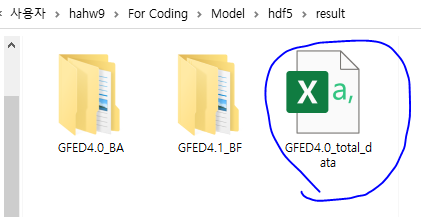

In [20]:
from IPython.display import Image
Image("C:/Users/hahw9/OneDrive/바탕 화면/Github Code/img.png")